**Importing the Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import os
from collections import OrderedDict
from tqdm.auto import tqdm
from pathlib import Path
import random
from typing import Dict, List
import warnings
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import random

warnings.filterwarnings("ignore")

**Load the Dataset**

In [3]:
# Define the path to the zip file
Data_zip_file = '/content/Dataset.zip'

# Define the directory where you want to extract the contents
Dataset = '/content/'

# Check if the zip file exists
if os.path.exists(Data_zip_file):
    # Open the zip file
    with zipfile.ZipFile(Data_zip_file, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(Dataset)
    print("Extraction complete.")
else:
    print("The specified zip file does not exist.")

Extraction complete.


**Checking Total Images**

In [4]:
train_path = Path('/content/Acne Severity Classification.v1i.folder/train')
total_train_images = sum(1 for _ in train_path.glob("*/*.jpg"))

# Count total images in the test folder
test_path = Path('/content/Acne Severity Classification.v1i.folder/test')
total_test_images = sum(1 for _ in test_path.glob("*/*.jpg"))

# Count total images in the test folder
valid_path = Path('/content/Acne Severity Classification.v1i.folder/valid')
total_valid_images = sum(1 for _ in valid_path.glob("*/*.jpg"))


print(f'Total Train Images = {total_train_images}')
print(f'Total Test Images = {total_test_images}')
print(f'Total Valid Images = {total_valid_images}')

Total Train Images = 772
Total Test Images = 48
Total Valid Images = 185


**Checking Each Class Images**

In [5]:
# Get a list of all classes (subdirectories) in the train folder
classes = [dir_entry.name for dir_entry in train_path.glob('*') if dir_entry.is_dir()]

# Print total classes
print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

# Count number of images per class
for c in classes:
    class_path = train_path / c
    total_images_class = sum(1 for _ in class_path.glob("*.jpg"))
    print(f"* {c}: {total_images_class} images")

****************************************
           Total Classes = 8
****************************************
* Eczemaa: 88 images
* IGA2: 69 images
* Rosacea: 88 images
* IGA0: 213 images
* Actinic Keratosis: 88 images
* Basal Cell Carcinoma: 88 images
* IGA4: 69 images
* IGA3: 69 images


In [6]:
# Get a list of all classes (subdirectories) in the testing folder
classes = [dir_entry.name for dir_entry in valid_path.glob('*') if dir_entry.is_dir()]

# Print total classes
print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

# Count number of images per class
for c in classes:
    class_path = valid_path / c
    total_images_class = sum(1 for _ in class_path.glob("*.jpg"))
    print(f"* {c}: {total_images_class} images")

****************************************
           Total Classes = 8
****************************************
* Eczemaa: 35 images
* IGA2: 7 images
* Rosacea: 37 images
* IGA0: 19 images
* Actinic Keratosis: 37 images
* Basal Cell Carcinoma: 37 images
* IGA4: 8 images
* IGA3: 5 images


In [7]:
# Get a list of all classes (subdirectories) in the testing folder
classes = [dir_entry.name for dir_entry in test_path.glob('*') if dir_entry.is_dir()]

# Print total classes
print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

# Count number of images per class
for c in classes:
    class_path = test_path / c
    total_images_class = sum(1 for _ in class_path.glob("*.jpg"))
    print(f"* {c}: {total_images_class} images")

****************************************
           Total Classes = 8
****************************************
* Eczemaa: 7 images
* IGA2: 3 images
* Rosacea: 7 images
* IGA0: 9 images
* Actinic Keratosis: 7 images
* Basal Cell Carcinoma: 7 images
* IGA4: 3 images
* IGA3: 5 images


**Displaying Some Images**

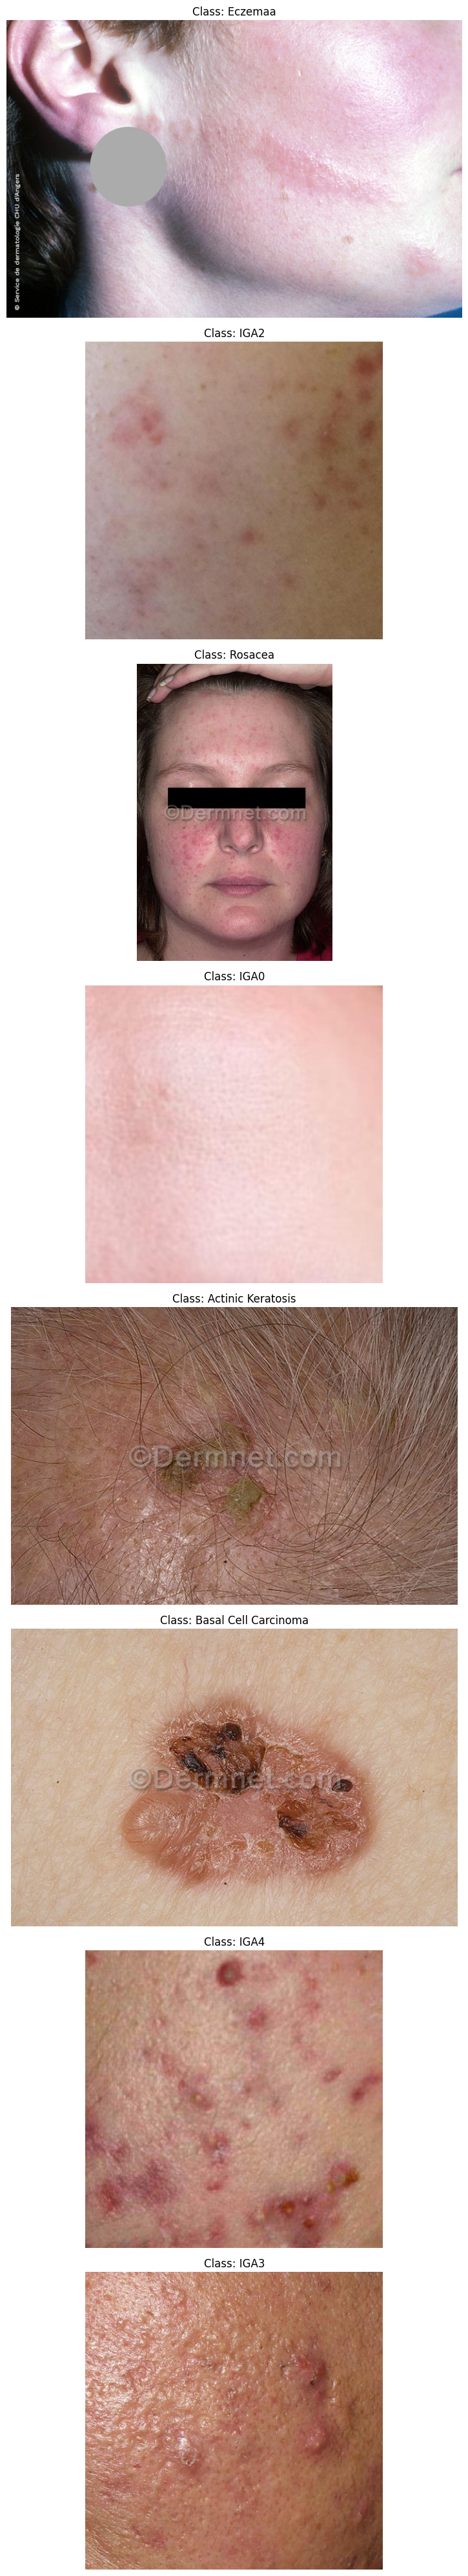

In [8]:
# Get a list of all classes (subdirectories) in the testing folder
classes = [dir_entry.name for dir_entry in test_path.glob('*') if dir_entry.is_dir()]

# Display an image from each class with its label
plt.figure(figsize=(15, len(classes)*5))

for i, c in enumerate(classes, start=1):
    class_path = test_path / c
    image_path = random.choice(list(class_path.glob("*.jpg")))  # Pick a random image from the class
    image = mpimg.imread(str(image_path))
    plt.subplot(len(classes), 1, i)
    plt.imshow(image)
    plt.title(f"Class: {c}")
    plt.axis('off')

plt.tight_layout()
plt.show()

<h1>Assigning Labels</h1>

**train images**

In [9]:
IMAGE_PATH_train = Path('/content/Acne Severity Classification.v1i.folder/train')
IMAGE_PATH_LIST_train = list(IMAGE_PATH_train.glob("*/*.jpg"))

In [10]:
images_path = [None] * len(IMAGE_PATH_LIST_train)
labels = [None] * len(IMAGE_PATH_LIST_train)

for i,image_path in enumerate(IMAGE_PATH_LIST_train):
    images_path[i] = image_path
    labels[i] = image_path.parent.stem

train_df = pd.DataFrame({'path':images_path,
                                  'label':labels})
train_df.head()

path    label
0  /content/Acne Severity Classification.v1i.fold...  Eczemaa
1  /content/Acne Severity Classification.v1i.fold...  Eczemaa
2  /content/Acne Severity Classification.v1i.fold...  Eczemaa
3  /content/Acne Severity Classification.v1i.fold...  Eczemaa
4  /content/Acne Severity Classification.v1i.fold...  Eczemaa

In [11]:
train_df['label'].unique()

array(['Eczemaa', 'IGA2', 'Rosacea', 'IGA0', 'Actinic Keratosis',
       'Basal Cell Carcinoma', 'IGA4', 'IGA3'], dtype=object)

**validation images**

In [12]:
IMAGE_PATH_valid = Path('/content/Acne Severity Classification.v1i.folder/valid')
IMAGE_PATH_LIST_valid = list(IMAGE_PATH_valid.glob("*/*.jpg"))

In [13]:
# Initialize lists to store image paths and labels
images_path = []
labels = []

# Iterate over the image paths and extract the label from the parent directory
for image_path in IMAGE_PATH_LIST_valid:
    images_path.append(image_path)
    labels.append(image_path.parent.name)  # Extracting the class label from the parent directory

# Create a DataFrame using the image paths and labels
valid_df = pd.DataFrame({'path': images_path, 'label': labels})
valid_df.head()

path    label
0  /content/Acne Severity Classification.v1i.fold...  Eczemaa
1  /content/Acne Severity Classification.v1i.fold...  Eczemaa
2  /content/Acne Severity Classification.v1i.fold...  Eczemaa
3  /content/Acne Severity Classification.v1i.fold...  Eczemaa
4  /content/Acne Severity Classification.v1i.fold...  Eczemaa

**test images**

In [14]:
IMAGE_PATH_test = Path('/content/Acne Severity Classification.v1i.folder/test')
IMAGE_PATH_LIST_test = list(IMAGE_PATH_test.glob("*/*.jpg"))

In [15]:
images_path = [None] * len(IMAGE_PATH_LIST_test)
labels = [None] * len(IMAGE_PATH_LIST_test)

for i,image_path in enumerate(IMAGE_PATH_LIST_test):
    images_path[i] = image_path
    labels[i] = image_path.parent.stem

test_df = pd.DataFrame({'path':images_path,
                                  'label':labels})
test_df.head()

path    label
0  /content/Acne Severity Classification.v1i.fold...  Eczemaa
1  /content/Acne Severity Classification.v1i.fold...  Eczemaa
2  /content/Acne Severity Classification.v1i.fold...  Eczemaa
3  /content/Acne Severity Classification.v1i.fold...  Eczemaa
4  /content/Acne Severity Classification.v1i.fold...  Eczemaa

In [16]:
# Convert Path objects to strings
train_df['path'] = train_df['path'].astype(str)
valid_df['path'] = valid_df['path'].astype(str)
test_df['path'] = test_df['path'].astype(str)


**Mapping Labels**

In [17]:
# Define a dictionary to map the existing labels to the desired labels
label_mapping = {
    'IGA0': 'Normal',
    'IGA1': 'Level1_acne',
    'IGA2': 'Level2_acne',
    'IGA3': 'Level3_acne',
    'Eczemaa':'Eczemaa',
    'Actinic Keratosis':'Actinic Keratosis',
    'Rosacea':'Rosacea',
    'Basal Cell Carcinoma':'Basal Cell Carcinoma'
}

# Replace labels in the DataFrame
train_df['label'] = train_df['label'].map(label_mapping)
valid_df['label'] = valid_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)


In [18]:
train_df['label'].unique()

array(['Eczemaa', 'Level2_acne', 'Rosacea', 'Normal', 'Actinic Keratosis',
       'Basal Cell Carcinoma', nan, 'Level3_acne'], dtype=object)

In [19]:
# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


**Data Preprocessing**

In [20]:
# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

In [21]:
# Define the number of classes (assuming you have extracted unique labels)
num_classes = len(train_df['label'].unique())
print(num_classes)

8


In [22]:
# Create a data generator for train and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [23]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# Create train and validation data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 772 validated image filenames belonging to 8 classes.
Found 185 validated image filenames belonging to 8 classes.


In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
# Define image size
image_size = (224, 224)

# Preprocess function
def preprocess_image(image_path, image_size=image_size):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Preprocess images and labels
X_train = np.concatenate([preprocess_image(path) for path in train_df['path']])
y_train = pd.get_dummies(train_df['label']).values


In [26]:
# Preprocess images and labels
X_valid = np.concatenate([preprocess_image(path) for path in valid_df['path']])
y_valid = pd.get_dummies(valid_df['label']).values

**Model**

In [27]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [28]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [29]:
# Load pretrained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [30]:
# Freeze the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)  # Adjust neurons based on dataset size
x = Dense(128, activation='relu')(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)


In [31]:
# Combine base model and custom head into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adjust learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=25,  # Adjust epochs based on dataset and validation performance
                    validation_data=(X_valid, y_valid))


Epoch 1/25
25/25 [==============================] - 21s 499ms/step - loss: 1.2389 - accuracy: 0.5570 - val_loss: 1.0165 - val_accuracy: 0.5892
Epoch 2/25
25/25 [==============================] - 10s 378ms/step - loss: 0.7083 - accuracy: 0.7047 - val_loss: 1.0798 - val_accuracy: 0.6270
Epoch 3/25
25/25 [==============================] - 9s 366ms/step - loss: 0.6689 - accuracy: 0.7461 - val_loss: 0.8988 - val_accuracy: 0.6757
Epoch 4/25
25/25 [==============================] - 10s 415ms/step - loss: 0.6279 - accuracy: 0.7655 - val_loss: 0.7663 - val_accuracy: 0.6703
Epoch 5/25
25/25 [==============================] - 10s 409ms/step - loss: 0.4582 - accuracy: 0.8290 - val_loss: 0.7539 - val_accuracy: 0.7189
Epoch 6/25
25/25 [==============================] - 10s 407ms/step - loss: 0.3855 - accuracy: 0.8575 - val_loss: 0.7626 - val_accuracy: 0.7351
Epoch 7/25
25/25 [==============================] - 9s 364ms/step - loss: 0.3611 - accuracy: 0.8601 - val_loss: 0.7422 - val_accuracy: 0.7135
E

**Model Evaluation**

In [37]:
# Preprocess images and labels
X_test = np.concatenate([preprocess_image(path) for path in test_df['path']])
y_test = pd.get_dummies(test_df['label']).values

In [38]:
# Evaluate the model
metrics = model.evaluate(X_test, y_test)
print("Test accuracy:", metrics[1])

2/2 [==============================] - 0s 81ms/step - loss: 0.6433 - accuracy: 0.7917
Test accuracy: 0.7916666865348816


2/2 [==============================] - 0s 117ms/step


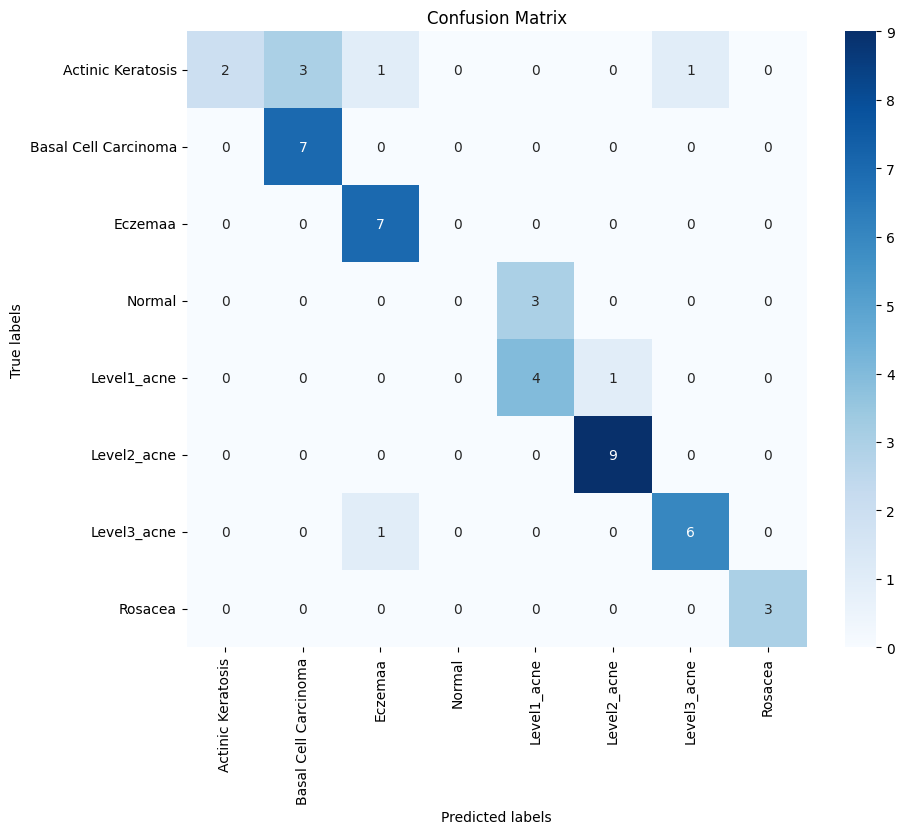

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Actinic Keratosis','Basal Cell Carcinoma','Eczemaa','Normal',  'Level1_acne','Level2_acne', 'Level3_acne','Rosacea']

# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred_classes, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred_classes, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("F1 score:", f1)


Accuracy: 0.7916666666666666
Precision: 0.777116402116402
Recall: 0.7916666666666666
F1 score: 0.7470930440889806


#Lotion Recommendation

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns

In [42]:
data = pd.read_excel('/content/Data for lotion Recommendation.xlsx')
data

Skin Condition    Lotion Brand  \
0     Acne Level 1          CeraVe   
1     Acne Level 1      Neutrogena   
2     Acne Level 2  La Roche-Posay   
3     Acne Level 2  Paula's Choice   
4     Acne Level 3        Differin   
..             ...             ...   
113   Acne Level 1           Biore   
114   Acne Level 1     Burt's Bees   
115   Acne Level 1   Clean & Clear   
116   Acne Level 1        Cetaphil   
117   Acne Level 2           Murad   

                                       Lotion Name  \
0                          Foaming Facial Cleanser   
1              Rapid Clear Stubborn Acne Face Wash   
2         Toleriane Double Repair Face Moisturizer   
3                 CLINICAL BHA 2% Liquid Exfoliant   
4                                              Gel   
..                                             ...   
113                Charcoal Acne Clearing Cleanser   
114  Natural Acne Solutions Purifying Gel Cleanser   
115             Advantage Acne Control Moisturizer   
116                          Daily Facial Cleanser   
117                               Clarifying Toner   

                         Key Ingredients           Recommended  
0            Salicylic Acid, Niacinamide                   Yes  
1                       Benzoyl Peroxide                   Yes  
2                Niacinamide, Ceramide-3                   Yes  
3                         Salicylic Acid                   Yes  
4                              Adapalene  Yes (consult doctor)  
..                                   ...                   ...  
113             Charcoal, Salicylic Acid                   Yes  
114  Salicylic Acid, Willow Bark Extract                   Yes  
115     Salicylic Acid, Benzoyl Peroxide                   Yes  
116           Propylene Glycol, Glycerin                   Yes  
117           Witch Hazel, Algae Extract                   Yes  

[118 rows x 5 columns]

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Skin Condition   118 non-null    object
 1   Lotion Brand     118 non-null    object
 2   Lotion Name      118 non-null    object
 3   Key Ingredients  118 non-null    object
 4   Recommended      118 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [44]:
data.describe()

Skin Condition Lotion Brand                              Lotion Name  \
count             118          118                                      118   
unique              7           43                                       66   
top           Rosacea        Murad  Tea Tree Skin Clearing Mattifying Toner   
freq               27           10                                        4   

                     Key Ingredients Recommended  
count                            118         118  
unique                            59           5  
top     Zinc Oxide, Titanium Dioxide         Yes  
freq                               5          79

**Plot Distribution of lotions**

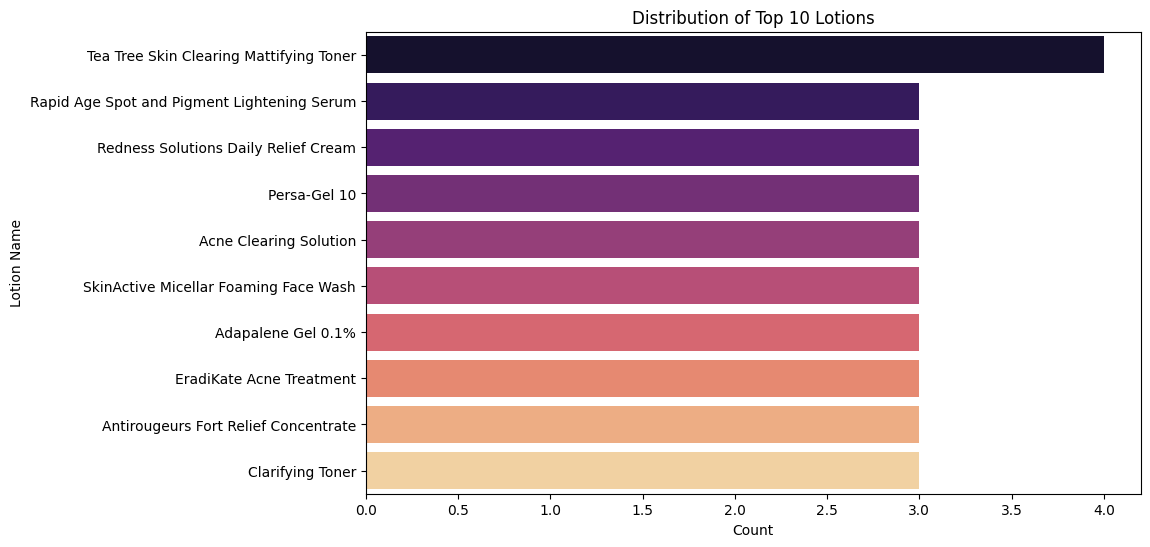

In [45]:
top_lotions = data['Lotion Name'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_lotions.values, y=top_lotions.index, palette='magma',hue=top_lotions.index)
plt.title('Distribution of Top 10 Lotions')
plt.xlabel('Count')
plt.ylabel('Lotion Name')
plt.show()

**Top Brands**

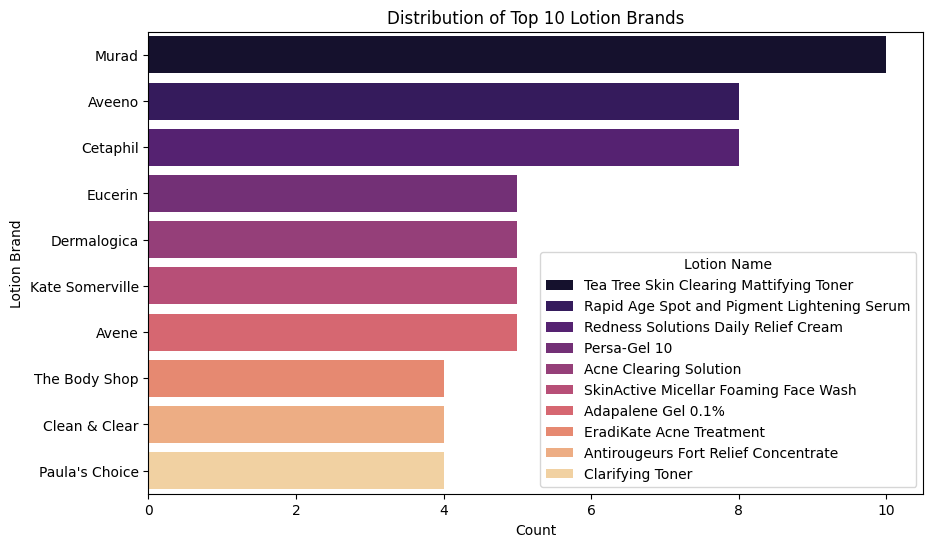

In [46]:
top_brands = data['Lotion Brand'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma',hue=top_lotions.index)
plt.title('Distribution of Top 10 Lotion Brands')
plt.xlabel('Count')
plt.ylabel('Lotion Brand')
plt.show()

In [47]:
# TF-IDF Vectorization
def tfidf_vectorization(data):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(data)
    return tfidf, tfidf_matrix


In [48]:
# Compute similarity scores
def compute_similarity(tfidf_matrix):
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_sim


In [49]:
# Recommend lotions based on skin condition
def recommend_lotions(df, condition, tfidf, cosine_sim):
    idx = df[df['Skin Condition'] == condition].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    lotion_indices = [i[0] for i in sim_scores]
    recommendations = df.iloc[lotion_indices]['Lotion Name']
    return recommendations


In [50]:
# Load data
def load_data(file_path):
    df = pd.read_excel(file_path)
    return df

In [51]:
# Load data
file_path = '/content/Data for lotion Recommendation.xlsx'
df = load_data(file_path)


In [52]:
# TF-IDF Vectorization
tfidf, tfidf_matrix = tfidf_vectorization(df['Lotion Name'])

In [53]:
# Compute similarity scores
cosine_sim = compute_similarity(tfidf_matrix)

In [54]:
# User interaction
condition = input("Enter the skin condition: ")

Enter the skin condition: Acne Level 1


In [55]:
recommendations = recommend_lotions(df, condition, tfidf, cosine_sim)

In [56]:
# Print recommendations
print("\nRecommended lotions for", condition, "are:")
print(recommendations)


Recommended lotions for Acne Level 1 are:
116               Daily Facial Cleanser
10               Gentle Facial Cleanser
56     EradiKate Daily Foaming Cleanser
90     EradiKate Daily Foaming Cleanser
13                   Ultra Facial Cream
Name: Lotion Name, dtype: object
